In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In this notebook I am going to do object detection by just writing the basic code and taking the image from the darknet repo itself.If you want to learn more about YOLOv4 you can read these blogs mention below:
- https://becominghuman.ai/explaining-yolov4-a-one-stage-detector-cdac0826cbd7
- https://towardsdatascience.com/pp-yolo-surpasses-yolov4-object-detection-advances-1efc2692aa62
- https://towardsdatascience.com/yolov4-in-google-colab-train-your-custom-dataset-traffic-signs-with-ease-3243ca91c81d


# What is YOLO
YOLO stands for You Only Look Once, it is an object detection system in real-time that recognizes various objects in a single enclosure. Moreover, it identifies objects more rapidly and more precisely than other recognition systems. <BR>
    
It can estimate up to 9000 and even more seen and unseen classes of objects. The real-time recognition system could recognize several objects from a particular image, frame a confined-edge box nearby objects, and quickly trained and implemented in a production system.
    
Now getting started towards it

# Clone and Build Darknet

In [ ]:
#clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

In [ ]:
#change directory to darknet
%cd darknet/

#change makefile to have a gpu and opencv
%cd darknet
!sed -i 

**Now make darknet so that we can use the darknet executable file to run and train object detetction**

In [ ]:
# make darknet
! make

# Download pre-trained YOLOv4 weights

**YOLOv4 has been trained already on the coco dataset.So we are going to download that weights**

In [ ]:
#download the newly released yolov4-tiny weights
%cd ./darknet
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.weights
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.conv.29

In [ ]:
#if you already have YOLO darknet format, you can skip this step
#otherwise we recommend formatting in Roboflow
!curl -L "https://app.roboflow.com/ds/MwqoUvnApc?key=LRDwgzBXrw" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

In [ ]:
#Set up training file directories for custom dataset
%cd ./darknet/
%cp train/_darknet.labels data/obj.names
%mkdir data/obj
#copy image and labels
%cp train/*.jpg data/obj/
%cp valid/*.jpg data/obj/

%cp train/*.txt data/obj/
%cp valid/*.txt data/obj/

with open('data/obj.data', 'w') as out:
    out.write('classes = 3\n')
    out.write('train = data/train.txt\n')
    out.write('valid = data/valid.txt\n')
    out.write('names = data/obj.names\n')
    out.write('backup = backup/')

#write train file (just the image list)
import os

with open('data/train.txt', 'w') as out:
    for img in [f for f in os.listdir('train') if f.endswith('jpg')]:
        out.write('data/obj/' + img + '\n')

#write the valid file (just the image list)
import os

with open('data/valid.txt', 'w') as out:
    for img in [f for f in os.listdir('valid') if f.endswith('jpg')]:
        out.write('data/obj/' + img + '\n')

# Run our detection with Darknet and YOLOv4

**The object detector can be run using the following commands :**

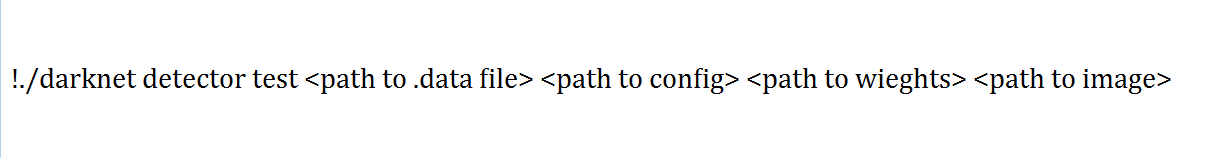

In this I am taking the horse image from the darknet repository itself.You can take any image which you want to detect.You can check which classes YOLOv4 can detect by visiting this site https://cocodataset.org/#explore

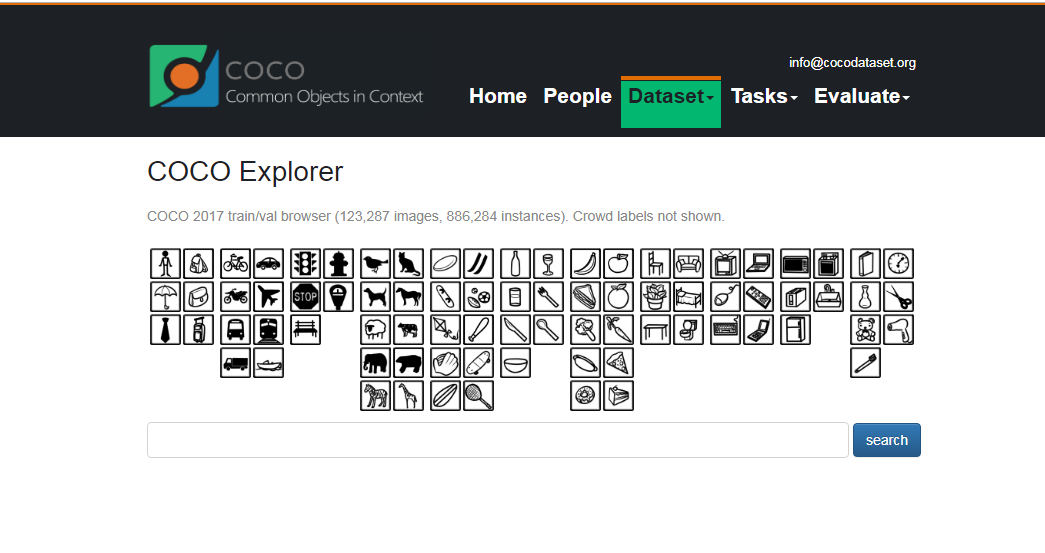

Above is the image of classes that YOLOv4 can detect.

In [ ]:
#we build config dynamically based on number of classes
#we build iteratively from base config files. This is the same file shape as cfg/yolo-obj.cfg
def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

num_classes = file_len('train/_darknet.labels')
max_batches = num_classes*2000
steps1 = .8 * max_batches
steps2 = .9 * max_batches
steps_str = str(steps1)+','+str(steps2)
num_filters = (num_classes + 5) * 3


print("writing config for a custom YOLOv4 detector detecting number of classes: " + str(num_classes))

#Instructions from the darknet repo
#change line max_batches to (classes*2000 but not less than number of training images, and not less than 6000), f.e. max_batches=6000 if you train for 3 classes
#change line steps to 80% and 90% of max_batches, f.e. steps=4800,5400
if os.path.exists('./cfg/custom-yolov4-tiny-detector.cfg'): os.remove('./cfg/custom-yolov4-tiny-detector.cfg')


#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate ./cfg/custom-yolov4-tiny-detector.cfg
[net]
# Testing
#batch=1
#subdivisions=1
# Training
batch=1
subdivisions=24
width=416
height=416
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.00261
burn_in=1000
max_batches = {max_batches}
policy=steps
steps={steps_str}
scales=.1,.1

[convolutional]
batch_normalize=1
filters=32
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[route]
layers=-1
groups=2
group_id=1

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=leaky

[route]
layers = -1,-2

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=leaky

[route]
layers = -6,-1

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[route]
layers=-1
groups=2
group_id=1

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[route]
layers = -1,-2

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[route]
layers = -6,-1

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[route]
layers=-1
groups=2
group_id=1

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[route]
layers = -1,-2

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[route]
layers = -6,-1

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=leaky

##################################

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=leaky

[convolutional]
size=1
stride=1
pad=1
filters={num_filters}
activation=linear



[yolo]
mask = 3,4,5
anchors = 10,14,  23,27,  37,58,  81,82,  135,169,  344,319
classes={num_classes}
num=6
jitter=.3
scale_x_y = 1.05
cls_normalizer=1.0
iou_normalizer=0.07
iou_loss=ciou
ignore_thresh = .7
truth_thresh = 1
random=0
nms_kind=greedynms
beta_nms=0.6

[route]
layers = -4

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[upsample]
stride=2

[route]
layers = -1, 23

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[convolutional]
size=1
stride=1
pad=1
filters={num_filters}
activation=linear

[yolo]
mask = 1,2,3
anchors = 10,14,  23,27,  37,58,  81,82,  135,169,  344,319
classes={num_classes}
num=6
jitter=.3
scale_x_y = 1.05
cls_normalizer=1.0
iou_normalizer=0.07
iou_loss=ciou
ignore_thresh = .7
truth_thresh = 1
random=0
nms_kind=greedynms
beta_nms=0.6

In [ ]:
#here is the file that was just written. 
#you may consider adjusting certain things

#like the number of subdivisions 64 runs faster but Colab GPU may not be big enough
#if Colab GPU memory is too small, you will need to adjust subdivisions to 16
%cat cfg/custom-yolov4-tiny-detector.cfg

In [ ]:
!./darknet detector train data/obj.data cfg/custom-yolov4-tiny-detector.cfg yolov4-tiny.conv.29 -dont_show -map

In [ ]:
#utility function
def imShow(path):
    import cv2
    import matplotlib.pyplot as plt
    %matplotlib inline

    image = cv2.imread(path)
    height, width = image.shape[:2]
    resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

    fig = plt.gcf()
    fig.set_size_inches(18, 10)
    plt.axis("off")
    #plt.rcParams['figure.figsize'] = [10, 5]
    plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
    plt.show()

In [ ]:
imShow("chart_yolov4-tiny.png")

In [ ]:
#check if weigths have saved yet
#backup houses the last weights for our detector
#(file yolo-obj_last.weights will be saved to the build\darknet\x64\backup\ for each 100 iterations)
#(file yolo-obj_xxxx.weights will be saved to the build\darknet\x64\backup\ for each 1000 iterations)
#After training is complete - get result yolo-obj_final.weights from path build\darknet\x64\bac
!ls backup
#if it is empty you haven't trained for long enough yet, you need to train for at least 100 iterations

In [ ]:
#coco.names is hardcoded somewhere in the detector
%cp data/obj.names data/coco.names

In [ ]:
#/test has images that we can test our detector on
test_images = [f for f in os.listdir('test') if f.endswith('.jpg')]
import random
img_path = "test/" + random.choice(test_images);

#test out our detector!
!./darknet detect cfg/custom-yolov4-tiny-detector.cfg backup/custom-yolov4-tiny-detector_best.weights {img_path} -dont-show
imShow('./darknet/predictions.jpg')